In [3]:
# SVM Line Following - Regression Model Training (with Progress Bar for Jupyter Notebook)

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm.notebook import tqdm  # For progress bar

# --- CONFIGURATION ---
IMAGE_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\processed_dataset"  # ✅ Update this path
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\floating_labels.csv"    # ✅ Update this path
MODEL_PATH = "svm_line_follower_model.pkl"

# --- LOAD DATA ---
df = pd.read_csv(LABEL_CSV)

def assign_bin(val):
    if val < -0.34:
        return 'left'
    elif val > 0.34:
        return 'right'
    else:
        return 'straight'

# Add bin labels for stratified splitting
df['bin'] = df['Maneuvering'].apply(assign_bin)

# --- FEATURE EXTRACTION FUNCTION ---
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None

    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([35, 50, 50])   # green-cyan range
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)

    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        norm_cx = cx / img.shape[1]  # normalized x-position
        return [norm_cx]
    else:
        return None

# --- EXTRACT FEATURES WITH PROGRESS BAR ---
X, y, bins = [], [], []
for _, row in tqdm(df.iterrows(), total=len(df), desc="🔍 Extracting features"):
    img_path = os.path.join(IMAGE_FOLDER, row['filename'])
    features = extract_features(img_path)
    if features is not None:
        X.append(features)
        y.append(row['Maneuvering'])
        bins.append(assign_bin(row['Maneuvering']))

X = np.array(X)
y = np.array(y)

# --- STRATIFIED SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=bins
)

# --- FEATURE SCALING ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- TRAINING THE MODEL ---
model = SVR(kernel='rbf', C=10, epsilon=0.05)
model.fit(X_train_scaled, y_train)

# --- EVALUATION ---
y_pred = model.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 Mean Absolute Error: {mae:.4f}")
print(f"📈 R2 Score: {r2:.4f}")

# --- SAVE MODEL ---
joblib.dump((model, scaler), MODEL_PATH)
print(f"💾 Model saved to {MODEL_PATH}")


🔍 Extracting features:   0%|          | 0/714 [00:00<?, ?it/s]

📊 Mean Absolute Error: 0.2393
📈 R2 Score: 0.4538
💾 Model saved to svm_line_follower_model.pkl


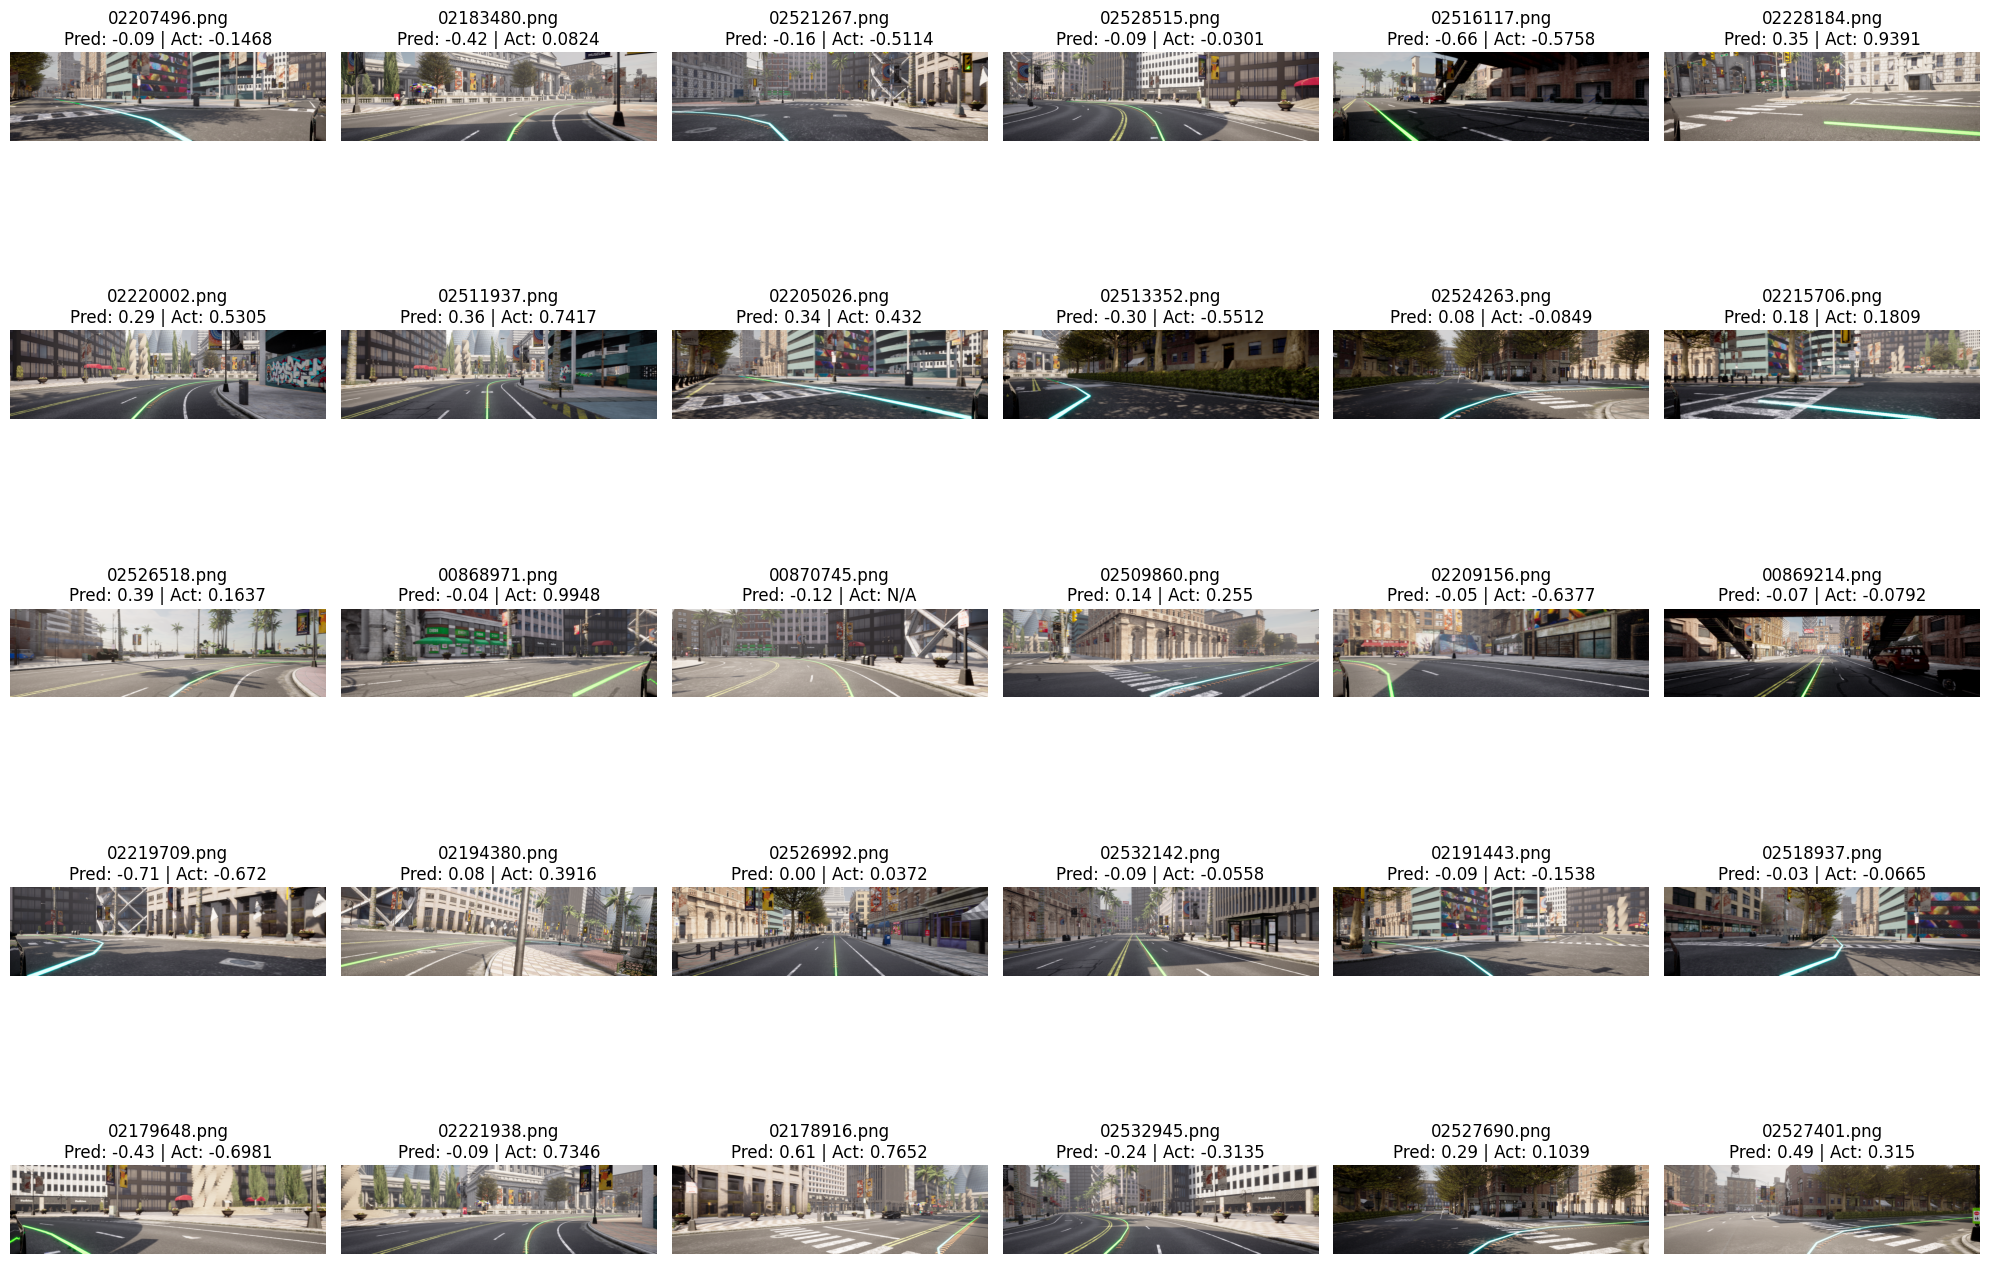

In [7]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import random
import pandas as pd

# === CONFIGURATION ===
MODEL_PATH = r"C:\Users\mcsmu\Desktop\Line Following SVM\svm_line_follower_model.pkl"
LABEL_CSV = r"C:\Users\mcsmu\Desktop\Line Following SVM\floating_labels.csv"
TEST_FOLDER = r"C:\Users\mcsmu\Desktop\Line Following SVM\test"

# === LOAD MODEL AND LABELS ===
model, scaler = joblib.load(MODEL_PATH)
label_df = pd.read_csv(LABEL_CSV).set_index('filename')

# === FEATURE EXTRACTION FUNCTION ===
def extract_features(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower = np.array([35, 50, 50])
    upper = np.array([95, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    moments = cv2.moments(mask)
    if moments["m00"] != 0:
        cx = int(moments["m10"] / moments["m00"])
        norm_cx = cx / img.shape[1]
        return [norm_cx]
    return None

# === GET RANDOM IMAGES ===
all_images = [f for f in os.listdir(TEST_FOLDER) if f.lower().endswith((".png", ".jpg", ".jpeg"))]
random_images = random.sample(all_images, min(30, len(all_images)))

# === PREDICT AND DISPLAY ===
cols = 6
rows = int(np.ceil(len(random_images) / cols))

plt.figure(figsize=(20, rows * 3))
for i, img_name in enumerate(random_images):
    img_path = os.path.join(TEST_FOLDER, img_name)
    features = extract_features(img_path)
    
    if features is None:
        print(f"⚠️ No line detected in {img_name}")
        continue

    input_scaled = scaler.transform([features])
    prediction = model.predict(input_scaled)[0]

    actual = label_df.loc[img_name, "Maneuvering"] if img_name in label_df.index else "N/A"

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"{img_name}\nPred: {prediction:.2f} | Act: {actual}")
    plt.axis("off")

plt.tight_layout()
plt.show()
